## Phase 04: Modelling

Similar to Part 01, we will be using a regression model to predict the `Thỏa thuận` price in the `Price` column.

But we are not going to use the same approach as Part 01. We are goint to use GridSearchCV to find the best models for our analysis, while tunning at the same time. We will still spend some time to compare our models, but we won't be cover them as precise as Part 01.

Let's start shall we.

### Import necessary Python modules

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score,mean_absolute_error

### Read data from file

In [60]:
data = pd.read_csv('rent_data_ready_for_ml.csv', index_col=0)

### Pre-process the data

The data is already processed after our previous phase. However, there are things we can do to improve the training process with this data, is to reduce the magnitute of the price number. For now, they are all number of over 6 digits, which could make the calculation process slower. Let's try to reduce that by changing the metric from `vnd` to `million vnd`. 

In [61]:
data['Price'] = data['Price'] / 1000000
data.rename({'Price': 'Price (million vnd)'}, inplace=True)

We also need to do is to remove the `Post data` column as we won't be using that for trainint.

In [62]:
data.drop(['Post date'], axis=1, inplace=True)

The data is now ready for training. For our model, we'll be focusing on predicting the price of `Căn hộ chung cư` property. 

In [63]:
data = data[data['Rent type'] == 'Căn hộ chung cư']

#### Detect outliner in the data

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

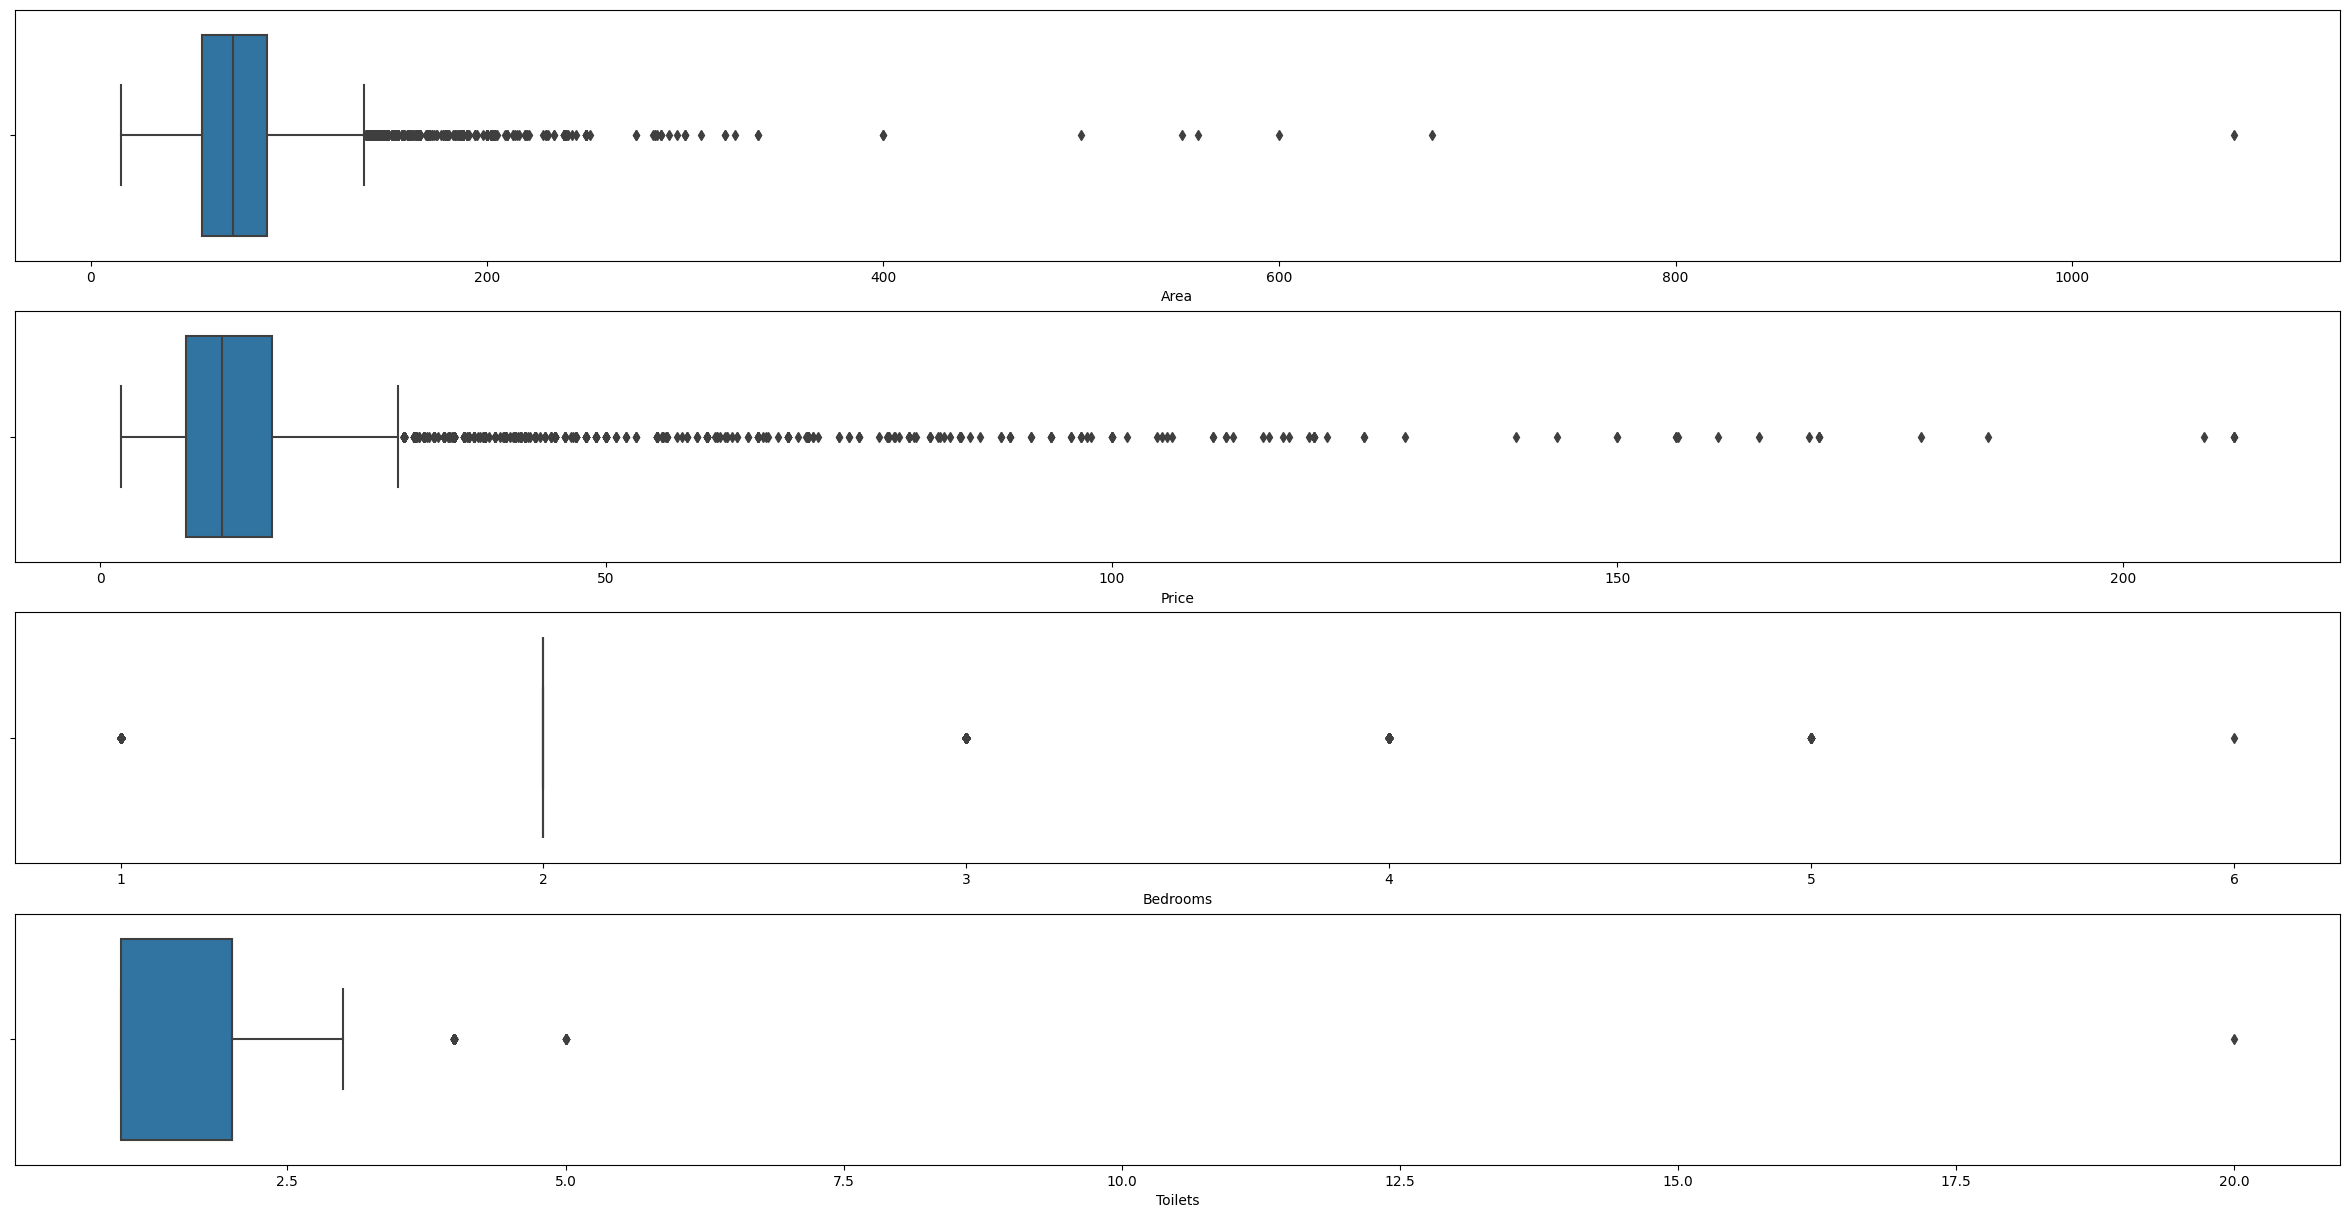

In [64]:
columns_to_plot = ['Area', 'Price', 'Bedrooms', 'Toilets']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

As we can see, there is a lot of outliner in all of the fields. 

Next, let's check for missing values in the data set.

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 38547
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rent type   10295 non-null  object 
 1   Area        10295 non-null  float64
 2   Price       10204 non-null  float64
 3   Bedrooms    9896 non-null   float64
 4   Toilets     9548 non-null   float64
 5   Furniture   10295 non-null  float64
 6   Floors      18 non-null     float64
 7   1           10295 non-null  bool   
 8   10          10295 non-null  bool   
 9   11          10295 non-null  bool   
 10  12          10295 non-null  bool   
 11  2           10295 non-null  bool   
 12  3           10295 non-null  bool   
 13  4           10295 non-null  bool   
 14  5           10295 non-null  bool   
 15  6           10295 non-null  bool   
 16  7           10295 non-null  bool   
 17  8           10295 non-null  bool   
 18  9           10295 non-null  bool   
 19  bình chánh  10295 non-null  bo

We can see that `Price`, `Bedroom`, `Toilets` and `Floors` all have missing values. 

To recap, we have to deal with the missing data for our predictive features, and the outliners in each columns.

First, let's deal with the missing data.

#### Resolve missing data

Since we are trying to build a model to predict the price of real estate rent property, we have to include `Price` data. There are 2 ways to resolve this situation:
- We filled in the missing data
- We delete the rows with missing data

With `Bedrooms` and `Toilets`, since the range of the data isn't so far off, let's fill in the missing values with mean of the values in the columns.

In [66]:
bedrooms_mean = int(data['Bedrooms'].mean())
toilet_mean = int(data['Toilets'].mean())

data['Bedrooms'].fillna(bedrooms_mean, inplace=True)
data['Toilets'].fillna(toilet_mean, inplace=True)

With `Floors`, since there are so many missing values, we are not accounting this data into our final dataset.

In [67]:
data.drop('Floors', axis=1, inplace=True)


With `Price` data, the missing data is the data that was the previously values `Thỏa thuận`. This is going to be our ultimate test dataset - the data that we want to predict the values of. Let's extract them from our dataset and remove from the test data set.

In [68]:
test_price_data = data[data['Price'].isna()]
data.dropna(subset=['Price'], inplace=True)

#### Resolve outliner

We will use the IQR method to remove the outliners in our dataset.

In [69]:
columns_to_plot = ['Area', 'Price', 'Bedrooms', 'Toilets']

In [70]:
for column in columns_to_plot:
    column_values = data[column].to_numpy()

    q1 = np.percentile(column_values, 25)
    q3 = np.percentile(column_values, 75)
    iqr = q3 - q1

    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr

    outliers_mask = (data[column] < lower_threshold) | (data[column] > upper_threshold)

    data = data[~outliers_mask]

Let's check our data again before moving on to building our model.

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4430 entries, 2 to 38486
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rent type   4430 non-null   object 
 1   Area        4430 non-null   float64
 2   Price       4430 non-null   float64
 3   Bedrooms    4430 non-null   float64
 4   Toilets     4430 non-null   float64
 5   Furniture   4430 non-null   float64
 6   1           4430 non-null   bool   
 7   10          4430 non-null   bool   
 8   11          4430 non-null   bool   
 9   12          4430 non-null   bool   
 10  2           4430 non-null   bool   
 11  3           4430 non-null   bool   
 12  4           4430 non-null   bool   
 13  5           4430 non-null   bool   
 14  6           4430 non-null   bool   
 15  7           4430 non-null   bool   
 16  8           4430 non-null   bool   
 17  9           4430 non-null   bool   
 18  bình chánh  4430 non-null   bool   
 19  bình thạnh  4430 non-null   boo

Looks like we have gone from 10295 to 9330 values - we've remove 965 values. 

Next, let's see how the data are distributed again with our contious features.

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

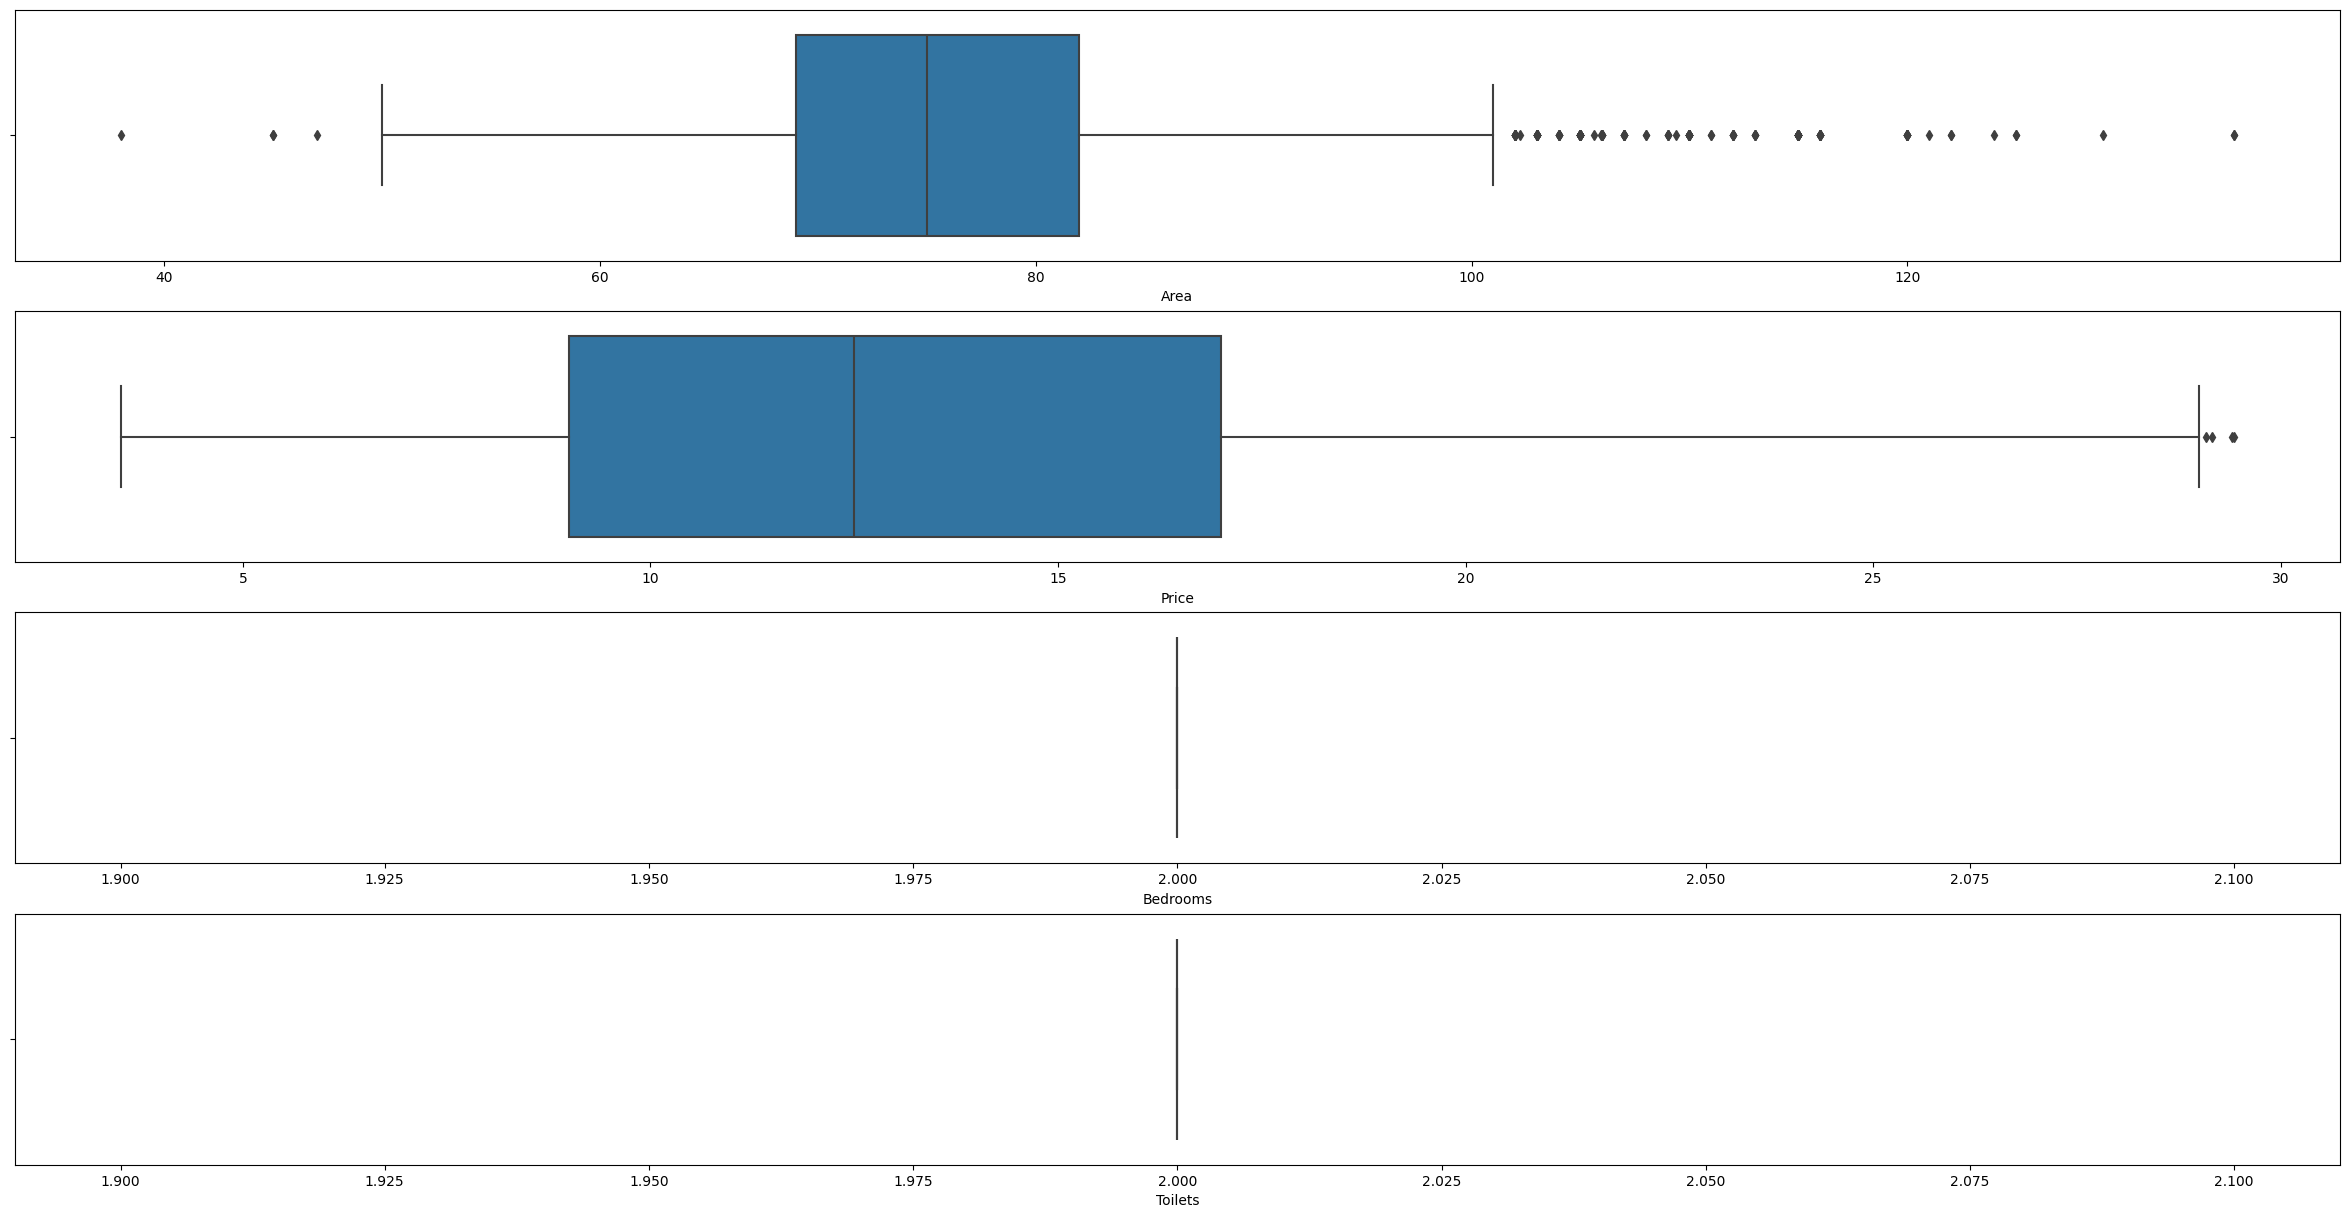

In [72]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

There are still some outliners left, but they are fewer and less significant.

Now, let's start training our models.

#### Model selection

There are flavors to model selection:
1. Using `cross_val_score`: This method allows us to measure the accuracy of a models on multiple datasets to determine the best score. 
2. Using `GridSearchCV`: This method allows us to tune hyperparameters of a model while feeding k-fold datasets to determine the best hyperparameter for the model.

In practice, we can use both to do model selection. But a more realist setting, Data Scientist would most likely use `GridSearchCV` to model select and tune at the same time. We are goint with the second approach as we have already gone with the first approach in part 01.

First, we're going to prepare our data, models and hyperparameters.

In [73]:
# Prepare predictors and response variable
## TODO: Re tweek this please
x = data.loc[:, ['Area', 'Bedrooms', 'Toilets', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']]
y = data['Price']

# Prepare models params
model_params = {
    'multiple_linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}
    },
    'lasso_regression': {
        'model': Lasso(),
        'params': {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}
    }, 
    'elasticnet_regression': {
        'model': ElasticNet(),
        'params': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.3, 0.7, 1]}
    },
    'dtree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'random_forest':{
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of trees in the forest
            'max_depth': [3, 5, 7, None],  # Maximum depth of the trees
            'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
        }
    }
}

Next, let's train our models and extract the results.

In [74]:
scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=10, refit='r2', return_train_score=False)
    clf.fit(x, y)

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'mean_score_time': np.mean(clf.cv_results_['mean_score_time']),
        'mean_fit_time': np.mean(clf.cv_results_['mean_fit_time'])
    })

KeyboardInterrupt: 

Here's the result of our program.

In [ ]:
pd.DataFrame(scores)

,model,best_score,best_params,mean_score_time,mean_fit_time
0,multiple_linear_regression,0.586792,{'fit_intercept': False},0.003780,0.025287
1,ridge_regression,0.586792,{'alpha': 0.1},0.001789,0.011436
2,lasso_regression,0.469918,{'alpha': 0.1},0.004720,0.030068
3,elasticnet_regression,0.480294,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.004020,0.024460
4,dtree_regression,0.539402,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.002299,0.010409
5,random_forest,0.702720,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.040638,2.654728


The `Random Forest Regression` model perform the best our of our models, scoring 0.7 on `r2`, but it also takes the most time to train - require 260 times more time than `Decision Tree Regression`.

Other than that, `Multiple Linear Regression` and `Ridge Regression` perform better than the rest at about 0.58 but still a lot worst than `Random Forest Regression`. `Decision Tree Regresion` comes in third, and `Lasso Regresison` and `ElasticNet Regression` comes in last at only about 0.46 to 0.48. The bad performance might be because both algorithm can tune out certain features, which cause the models to performs well. This could means that the majority of features that is choosen in our dataset is significant.

With the result, let's choose the `Ridge Regression` to predicts our price data, since its result is second best and the time it is that fasted model to train.

Now let's finally use our model to predict our price. As we have stated before, we will be using the `Decision Tree` regresison model.

In [75]:
# Predict the price base on the given information

# Using Ridge Regression and it determined best hyperparameter
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(x, y)
y_pred = ridge_regression.predict(test_price_data.loc[:, ['Area', 'Bedrooms', 'Toilets', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']])

In [78]:
test_price_data['Price'] = y_pred
test_price_data

,Rent type,Area,Price,Bedrooms,Toilets,Furniture,1,10,11,12,...,bình tân,củ chi,gò vấp,hóc môn,nhà bè,phú nhuận,thủ đức,tân bình,tân phú,Price(Million)
7,Căn hộ chung cư,99.0,17.298818,2.0,3.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,17.298818
13,Căn hộ chung cư,73.0,16.557190,2.0,1.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,16.557190
39,Căn hộ chung cư,72.0,16.411809,2.0,2.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,16.411809
105,Căn hộ chung cư,54.0,11.621876,1.0,1.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,11.621876
215,Căn hộ chung cư,84.0,18.871332,2.0,2.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,18.871332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32634,Căn hộ chung cư,120.0,23.390062,3.0,1.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,23.390062
32672,Căn hộ chung cư,75.0,17.311948,2.0,2.0,3.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,17.311948
33250,Căn hộ chung cư,70.0,10.276376,2.0,1.0,3.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,10.276376
33856,Căn hộ chung cư,118.0,20.061043,3.0,2.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,20.061043


Let's take a peek at our data to see if the result is reasonable.

In [79]:
print(test_price_data['Price'].max())
print(test_price_data['Price'].min())

43.393424571111005
5.391508269482823


We see that the price falls in a reasonable range. This is good, since that mean our models - although not perfect, is able to predict price range modestly and resonably.

That's conclude our model building process. Last but not least, we're be conluding by looking back at our project, what we have done right and what we could do better. 